# Peak Elbow Plots

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import scipy
from scipy import signal
from numpy import matlib

from NI_tools.NI_tools import inversion
import matplotlib.gridspec as gridspec


plt.rcParams.update({
    'text.usetex':True,
    'font.family':'serif',
    'font.size':7
})

import seaborn as sns
# set the theme
sns.set_palette('inferno', 3)


%load_ext autoreload
%autoreload 2

### Define functions

In [2]:
def piecewise_linear(x, x0, y0, k1, k2):
    '''
    piecewise_linear function

    Parameters
    ----------
    x : array like
        inputs to function
    x0 : float
        x of coordinate of corner
    y0 : float
        y coordinate of corner
    k1 : float
        slope of line 1
    k2 : float
        slope of line 2
    '''
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

def open_data(avg_hour):
    NCCFs = xr.open_dataarray(f'/datadrive/NCCFs/old/6year_NCCF_{avg_hour}.nc')
    nan_mask = np.isnan(NCCFs[::avg_hour,0]).values
    NCCFs = NCCFs[::avg_hour,:][~nan_mask,:]
    
    # construct peak dictionary
    peaks = {}
    peaks_f = {}
    peaks_f_us = {}
    f = {}

    # Calculate fft of peaks
    for peak_name in inversion.peak_names_short:
        peaks[peak_name] = NCCFs[:,inversion.peak_slices[peak_name]]
        peaks_f[peak_name] = np.abs(scipy.fft.fft(peaks[peak_name].values))
        peaks_f_us[peak_name] = np.abs(scipy.fft.fft(np.hstack((peaks[peak_name].values, np.zeros((peaks[peak_name].shape[0], 2048-peaks[peak_name].shape[1]))))))

    # slice to designed frequency bounds
    # This assumes uniform window width for all peaks
    flo = 5
    fhi = 80

    f = np.linspace(0,200,200)
    f_us = np.linspace(0,200,2048)

    fidx1 = np.argmin(np.abs(f-flo))
    fidx2 = np.argmin(np.abs(f-fhi))

    peaks_f_slice = {}
    for peak_name in peaks_f.keys():
        peaks_f_slice[peak_name] = peaks_f[peak_name][:,fidx1:fidx2]
        
    fs = np.ndarray.flatten(matlib.repmat(f[fidx1:fidx2], 1, NCCFs.shape[0]))
    
    fitted_lines = {}
    fitted_covs = {}
    for peak_name in inversion.peak_names_short:

        x = fs
        y = peaks_f_slice[peak_name].flatten()

        bounds = (np.array([f[fidx1],-100,-100,-0.00001]), np.array([f[fidx2], 100,100,0.00001]))
        popt, pcov = scipy.optimize.curve_fit(piecewise_linear, x,np.log10(y), bounds=bounds)

        fitted_lines[peak_name] = popt
        fitted_covs[peak_name] = pcov
    
    return peaks_f_us, fitted_lines

### open data
- only use samples with no overlap
- remove all nan values

In [4]:
peaks_f_us201, fitted_lines201 = open_data(201)
peaks_f_us601, fitted_lines601 = open_data(601)
peaks_f_us1001, fitted_lines1001 = open_data(1001)

f_us = np.linspace(0,200,2048)
f = np.linspace(0,200,200)

### Archive of pre-function code

In [5]:
avg_hour = 1001
NCCFs = xr.open_dataarray(f'/datadrive/NCCFs/old/6year_NCCF_{avg_hour}.nc')
nan_mask = np.isnan(NCCFs[::avg_hour,0]).values
NCCFs = NCCFs[::avg_hour,:][~nan_mask,:]

In [6]:
# construct peak dictionary
peaks = {}
peaks_f = {}
peaks_f_us = {}
f = {}

# Calculate fft of peaks
for peak_name in inversion.peak_names_short:
    peaks[peak_name] = NCCFs[:,inversion.peak_slices[peak_name]]
    peaks_f[peak_name] = np.abs(scipy.fft.fft(peaks[peak_name].values))
    peaks_f_us[peak_name] = np.abs(scipy.fft.fft(np.hstack((peaks[peak_name].values, np.zeros((peaks[peak_name].shape[0], 2048-peaks[peak_name].shape[1]))))))

# slice to designed frequency bounds
# This assumes uniform window width for all peaks
flo = 5
fhi = 80

f = np.linspace(0,200,200)
f_us = np.linspace(0,200,2048)

fidx1 = np.argmin(np.abs(f-flo))
fidx2 = np.argmin(np.abs(f-fhi))

peaks_f_slice = {}
for peak_name in peaks_f.keys():
    peaks_f_slice[peak_name] = peaks_f[peak_name][:,fidx1:fidx2]

In [7]:
fs = np.ndarray.flatten(matlib.repmat(f[fidx1:fidx2], 1, NCCFs.shape[0]))

In [8]:
def piecewise_linear(x, x0, y0, k1, k2):
    '''
    piecewise_linear function

    Parameters
    ----------
    x : array like
        inputs to function
    x0 : float
        x of coordinate of corner
    y0 : float
        y coordinate of corner
    k1 : float
        slope of line 1
    k2 : float
        slope of line 2
    '''
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

#### Fit Bilinear to spectrums

In [9]:
fitted_lines = {}
fitted_covs = {}
for peak_name in inversion.peak_names_short:

    x = fs
    y = peaks_f_slice[peak_name].flatten()
    
    bounds = (np.array([f[fidx1],-100,-100,-0.00001]), np.array([f[fidx2], 100,100,0.00001]))
    popt, pcov = scipy.optimize.curve_fit(piecewise_linear, x,np.log10(y), bounds=bounds)
    
    fitted_lines[peak_name] = popt
    fitted_covs[peak_name] = pcov

## Create figure

In [11]:
peaks_f_avghour = {
    '201':peaks_f_us201,
    '601':peaks_f_us601,
    '1001':peaks_f_us1001
}

fitted_lines_avghour = {
    '201':fitted_lines201,
    '601':fitted_lines601,
    '1001':fitted_lines1001
}

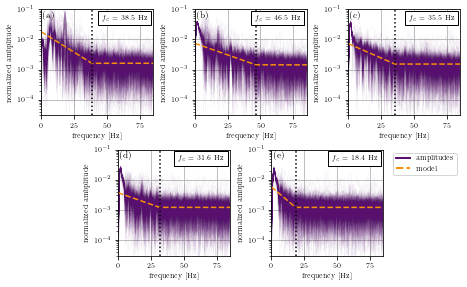

In [19]:
avg_hour = '201'

fig = plt.figure(figsize=(6.5, 4))
gs = gridspec.GridSpec(2, 6, figure=fig)

ax1 = fig.add_subplot(gs[0, :2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4:6])
ax4 = fig.add_subplot(gs[1, 1:3])
ax5 = fig.add_subplot(gs[1, 3:5])

axes = np.array([ax1, ax2, ax3, ax4, ax5])

k = 0
labels = ['(a)', '(b)', '(c)', '(d)','(e)']

for peak_name in inversion.peak_names_short:
    
    plt.sca(axes[k])
    _ = plt.plot(f_us, peaks_f_avghour[avg_hour][peak_name].T, 'C0', alpha=0.04, rasterized=True, linewidth=0.5)
    #_ = plt.plot(f_us, peaks_f_us1001[peak_name].T, 'C1', alpha=0.06, rasterized=True, linewidth=0.5)
    
    plt.plot(f, 10**piecewise_linear(f, fitted_lines_avghour[avg_hour][peak_name][0], fitted_lines_avghour[avg_hour][peak_name][1], fitted_lines_avghour[avg_hour][peak_name][2], fitted_lines_avghour[avg_hour][peak_name][3]), 'C2--')
    #plt.plot(f, 10**piecewise_linear(f, fitted_lines1001[peak_name][0], fitted_lines1001[peak_name][1], fitted_lines1001[peak_name][2], fitted_lines1001[peak_name][3]), 'C3--')
    
    plt.xlim([0,85])
    plt.ylim([3e-5,1e-1])

    ylims = plt.gca().get_ylim()
    plt.plot([fitted_lines_avghour[avg_hour][peak_name][0], fitted_lines_avghour[avg_hour][peak_name][0]], ylims,  'k:')
    #plt.plot(fitted_lines[peak_name][0], 10**fitted_lines[peak_name][1], 'wo', markeredgecolor='k', markersize=7,)
    plt.yscale('log')
    plt.xlabel('frequency [Hz]')
    plt.ylabel('normalized ambplitude')
    plt.grid()
    #plt.title(peak_name, fontsize=11)
    plt.xticks(np.arange(0,100,25))
    plt.yticks([1e-1, 1e-2, 1e-3, 1e-4])
    
    #plt.text(51,1e-2, f'$f_c$ = {fitted_lines[peak_name][0]:.4} Hz\nslope={10**(fitted_lines[peak_name][2]/10):.4} dB/Hz\nnoise floor = {10**fitted_lines[peak_name][1]:.2e}', fontsize=8, bbox=dict(facecolor='white', edgecolor='black'))
    plt.text(0.54,0.9, f'$f_c$ = {fitted_lines_avghour[avg_hour][peak_name][0]:.1f} Hz', bbox=dict(facecolor='white', edgecolor='black'), transform=axes[k].transAxes)
    
    plt.text(1,0.05, labels[k], fontsize=9)#, bbox=dict(facecolor='white', alpha=1))
    k += 1


leg_ax = fig.add_subplot(gs[1,5])
# Remove the face and axis bounds
leg_ax.set_facecolor('none')
leg_ax.spines['top'].set_visible(False)
leg_ax.spines['right'].set_visible(False)
leg_ax.spines['bottom'].set_visible(False)
leg_ax.spines['left'].set_visible(False)
leg_ax.tick_params(left=False, bottom=False)
leg_ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

# Define the colors and labels for the legend
colors = ['C0', 'C1']
labels = ['amplitudes', 'model']

# Create custom lines for the legend

lines = [
    Line2D([0], [0], color='C0', linewidth=2, linestyle='-'),
    Line2D([0], [0], color='C2', linewidth=2, linestyle='--')
]

# Create the legend
leg_ax.legend(lines, labels)

plt.tight_layout()

fig.savefig(f'figures/elbow_plot_{avg_hour}.svg', dpi=450)

### Experiment with multiple average hours

In [ ]:
fig = plt.figure(figsize=(6.5, 4))
gs = gridspec.GridSpec(2, 6, figure=f)

ax1 = fig.add_subplot(gs[0, :2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4:6])
ax4 = fig.add_subplot(gs[1, 1:3])
ax5 = fig.add_subplot(gs[1, 3:5])

axes = np.array([ax1, ax2, ax3, ax4, ax5])

k = 0
labels = ['(a)', '(b)', '(c)', '(d)','(e)']

for peak_name in inversion.peak_names_short:
    
    plt.sca(axes[k])
    _ = plt.plot(f_us, peaks_f_us[peak_name].T, 'C0', alpha=0.06, rasterized=True, linewidth=0.5)
    plt.plot(f, 10**piecewise_linear(f, fitted_lines[peak_name][0], fitted_lines[peak_name][1], fitted_lines[peak_name][2], fitted_lines[peak_name][3]), 'C2--')

    plt.xlim([0,85])
    plt.ylim([3e-5,1e-1])

    ylims = plt.gca().get_ylim()
    plt.plot([fitted_lines[peak_name][0], fitted_lines[peak_name][0]], ylims,  'k:')
    #plt.plot(fitted_lines[peak_name][0], 10**fitted_lines[peak_name][1], 'wo', markeredgecolor='k', markersize=7,)
    plt.yscale('log')
    #plt.xlabel('frequency [Hz]')
    #plt.ylabel('normalized ambplitude')
    plt.grid()
    #plt.title(peak_name, fontsize=11)
    plt.xticks(np.arange(0,100,25))
    plt.yticks([1e-1, 1e-2, 1e-3, 1e-4])
    
    #plt.text(51,1e-2, f'$f_c$ = {fitted_lines[peak_name][0]:.4} Hz\nslope={10**(fitted_lines[peak_name][2]/10):.4} dB/Hz\nnoise floor = {10**fitted_lines[peak_name][1]:.2e}', fontsize=8, bbox=dict(facecolor='white', edgecolor='black'))
    plt.text(0.58,0.9, f'$f_c$ = {fitted_lines[peak_name][0]:.1f} Hz', bbox=dict(facecolor='white', edgecolor='black'), transform=axes[k].transAxes)
    
    plt.text(1,0.05, labels[k], fontsize=9)
    k += 1
    
plt.tight_layout()

fig.savefig(f'figures/elbow_plot_{avg_hour}.pdf', dpi=450)

## Print out corner frequencies

In [20]:
print(f'201 hours averaging')
print('| peak\t | fc\t\t\t | noise floor\t\t | slope')
print('---------------------------------------------------------------------------------')
for key in fitted_lines201.keys():
    print(f'| {key}\t | {fitted_lines201[key][0]}\t | {10**fitted_lines201[key][1]:.18f}\t | {20*fitted_lines201[key][2]}\t')

201 hours averaging
| peak	 | fc			 | noise floor		 | slope
---------------------------------------------------------------------------------
| dA	 | 38.49644799876388	 | 0.001620718465839122	 | -0.5456242567860011	
| s1b0A	 | 46.45346687092607	 | 0.001438587296664326	 | -0.309163596060631	
| s1b0B	 | 35.528258201431036	 | 0.001527862190425525	 | -0.3831489708803393	
| s2b1A	 | 31.60147483493909	 | 0.001205334047311096	 | -0.3097353650532677	
| s2b1B	 | 18.426651669398172	 | 0.001204021364309506	 | -0.7418323489478057	


In [24]:
print(f'601 hours averaging')
print('| peak\t | fc\t\t\t | noise floor\t\t | slope')
print('---------------------------------------------------------------------------------')
for key in fitted_lines601.keys():
    print(f'| {key}\t | {fitted_lines601[key][0]}\t | {10**fitted_lines601[key][1]:.18f}\t | {20*fitted_lines601[key][2]}\t')

601 hours averaging
| peak	 | fc			 | noise floor		 | slope
---------------------------------------------------------------------------------
| dA	 | 40.55017262364214	 | 0.001157318729199247	 | -0.6089221475648051	
| s1b0A	 | 54.724490650555055	 | 0.000956443554608162	 | -0.3159983258669477	
| s1b0B	 | 38.998664801096524	 | 0.001089752400978035	 | -0.41837597347503447	
| s2b1A	 | 34.214072643236165	 | 0.000763964254995439	 | -0.36765872155846724	
| s2b1B	 | 24.394969444999766	 | 0.000710437654624315	 | -0.6199590657780898	


In [23]:
print(f'1001 hours averaging')
print('| peak\t | fc\t\t\t | noise floor\t\t | slope')
print('---------------------------------------------------------------------------------')
for key in fitted_lines1001.keys():
    print(f'| {key}\t | {fitted_lines1001[key][0]}\t | {10**fitted_lines1001[key][1]:.18f}\t | {20*fitted_lines1001[key][2]}\t')

1001 hours averaging
| peak	 | fc			 | noise floor		 | slope
---------------------------------------------------------------------------------
| dA	 | 42.36289799469905	 | 0.001015389435532303	 | -0.6102166734561563	
| s1b0A	 | 60.603626021214424	 | 0.000789545940561137	 | -0.3040872936559424	
| s1b0B	 | 40.2010426874647	 | 0.000967901850930001	 | -0.4321037146045292	
| s2b1A	 | 35.17584754198018	 | 0.000623296421451311	 | -0.4088842047768487	
| s2b1B	 | 26.25266444094792	 | 0.000565372938407324	 | -0.6231131852378065	


# NEED TO FIX SLOPE VALUES!

In [30]:
f = np.linspace(0,100,1000)
y = piecewise_linear(f, fitted_lines201['s1b0A'][0], fitted_lines201['s1b0A'][1], fitted_lines201['s1b0A'][2], fitted_lines201['s1b0A'][3])

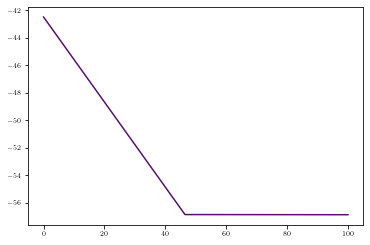

In [33]:
plt.plot(f,20*np.log10(10**y))

In [35]:
20*np.log10(10**fitted_lines201['s1b0A'][2])

-0.30916359606063143

In [36]:
20*fitted_lines201['s1b0A'][2]

-0.309163596060631